# Install and import libraries

In [1]:
%pip install pydot
%pip install tensorflow
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from pathlib import Path

from constants import (
    DATA_INPUT_PATH,
    CLASSES,
    MODEL_PATH,
    METADATA_PATH,
)

# Read the files in the data dir

In [94]:
# Read all of the files in the data folder
files_in_folder = Path(DATA_INPUT_PATH).rglob("*.csv")

files = [x for x in files_in_folder]
print([file for file in files])

[WindowsPath('data/7_4.csv')]


## Convert .csv(s) to dataframes and concatenate

In [95]:
# Read the data from the files
dfs = []

for file in files:
    df = pd.read_csv(str(file))
    dfs.append(df)
        
# Convert the data to a DataFrame
df = pd.concat([x for x in dfs], axis=0)

print(df.head())

# Before removing duplicates
print(f"Shape of dataframe before removing duplicates {df.shape}")
# Remove duplicates
df = df.drop_duplicates()
print(f"Shape of dataframe after removing duplicates {df.shape}")

# remove rows where the label is 0 or 1
# df = df[df["Label"] != 0] # unmarked
# df = df[df["Label"] != 1] # rest

# Print out the columns
# classes = {
#     "0": "unmarked",
#     "1": "rest",
#     "2": "clenched_fist",
#     "3": "wrist_flexion",
#     "4": "wrist_extension",
#     "5": "radial_deviations",
#     "6": "ulnar_deviations",
#     "7": "extended_palm"
# }

   Sensor1  Sensor2  Sensor3  Sensor4  Sensor5  Sensor6  Sensor7  Sensor8  \
0       -1        1       -1       -5       -7       -3       -2       -1   
1        1        1        2        3        1        1        1        0   
2       -1        1       -3       -2       -2        5        2        1   
3       -2        0       -2        0       -5        2        0        1   
4       -2       -2       -3       -4        4       -4       -2       -2   

   Sensor9  Sensor10  Sensor11  Sensor12  Sensor13  Sensor14  Sensor15  \
0       -2        -2        -2         0        12         5        -1   
1       -1        -3         0        -2        -2        -2        -1   
2        1         0        -1        -1        -7       -11        -2   
3        1         0        -1        -1        -2        -1         3   
4       -2        -3        -3        -2        24         4        -1   

   Sensor16  Label  
0        -2      0  
1        -1      0  
2         0      0  
3       

## Visualise the dataset

In [98]:
CLASSES = {
    0: "rest", #saftey
    1: "closed_fist", #go up
    2: "open_palm", #go down
    3: "ok", #go forwards
    4: "pointer_finger", #go backwards
    5: "peace", #roatate left
    6: "shaaa", #rotate right
    7: "peace_among_worlds", #do a flip
}


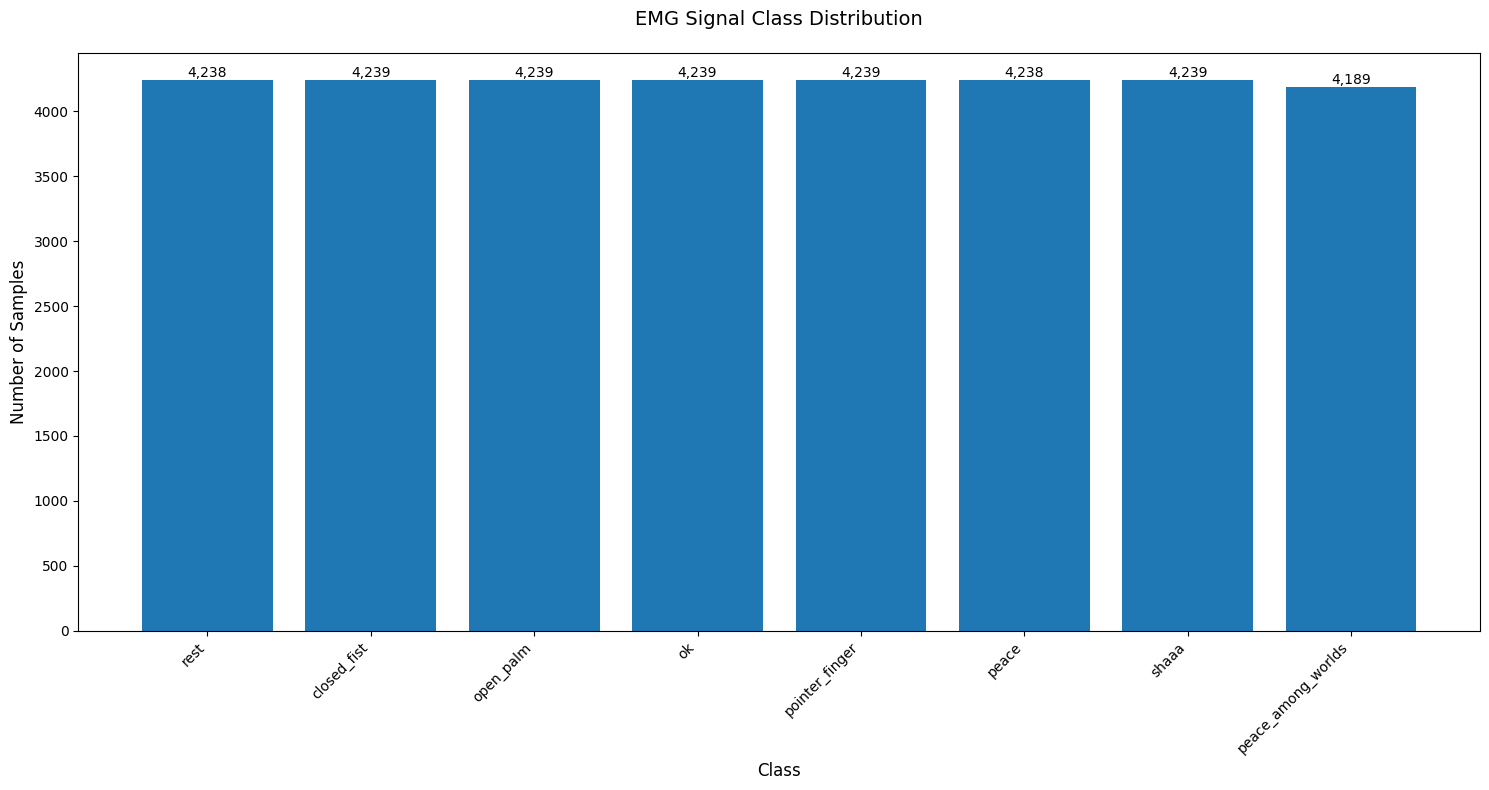

In [99]:
class_counts = df['Label'].value_counts().sort_index()

plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(class_counts)), class_counts.values)

plt.title('EMG Signal Class Distribution', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

# Set x-axis ticks with class labels
plt.xticks(range(len(class_counts)), [CLASSES[i] for i in range(len(class_counts))], rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

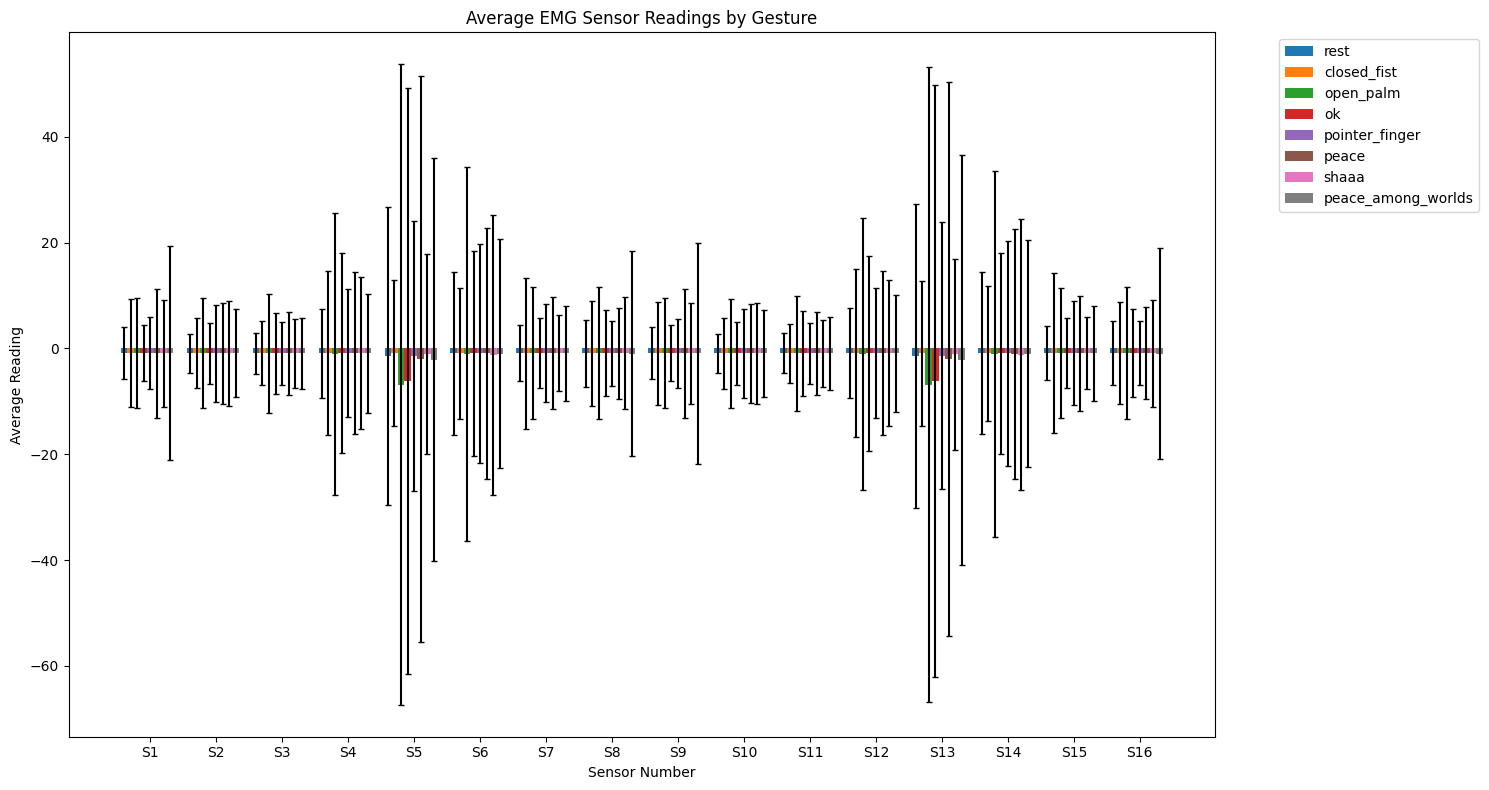

In [100]:
# Group data by label and calculate mean for each sensor
sensor_avgs = []
sensor_stds = []

for label in range(8):
    label_data = df[df['Label'] == label].drop('Label', axis=1)
    sensor_avgs.append(label_data.mean().values)
    sensor_stds.append(label_data.std().values)

sensor_avgs = np.array(sensor_avgs)
sensor_stds = np.array(sensor_stds)

# Set up the plot
plt.figure(figsize=(15, 8))

# Plot bars for each gesture
x = np.arange(16)
width = 0.1
for i in range(8):
    plt.bar(x + i*width, sensor_avgs[i], width, 
            label=CLASSES[i],
            yerr=sensor_stds[i],
            capsize=2)

# Customize the plot
plt.xlabel('Sensor Number')
plt.ylabel('Average Reading')
plt.title('Average EMG Sensor Readings by Gesture')
plt.xticks(x + width*4, [f'S{i+1}' for i in range(16)])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

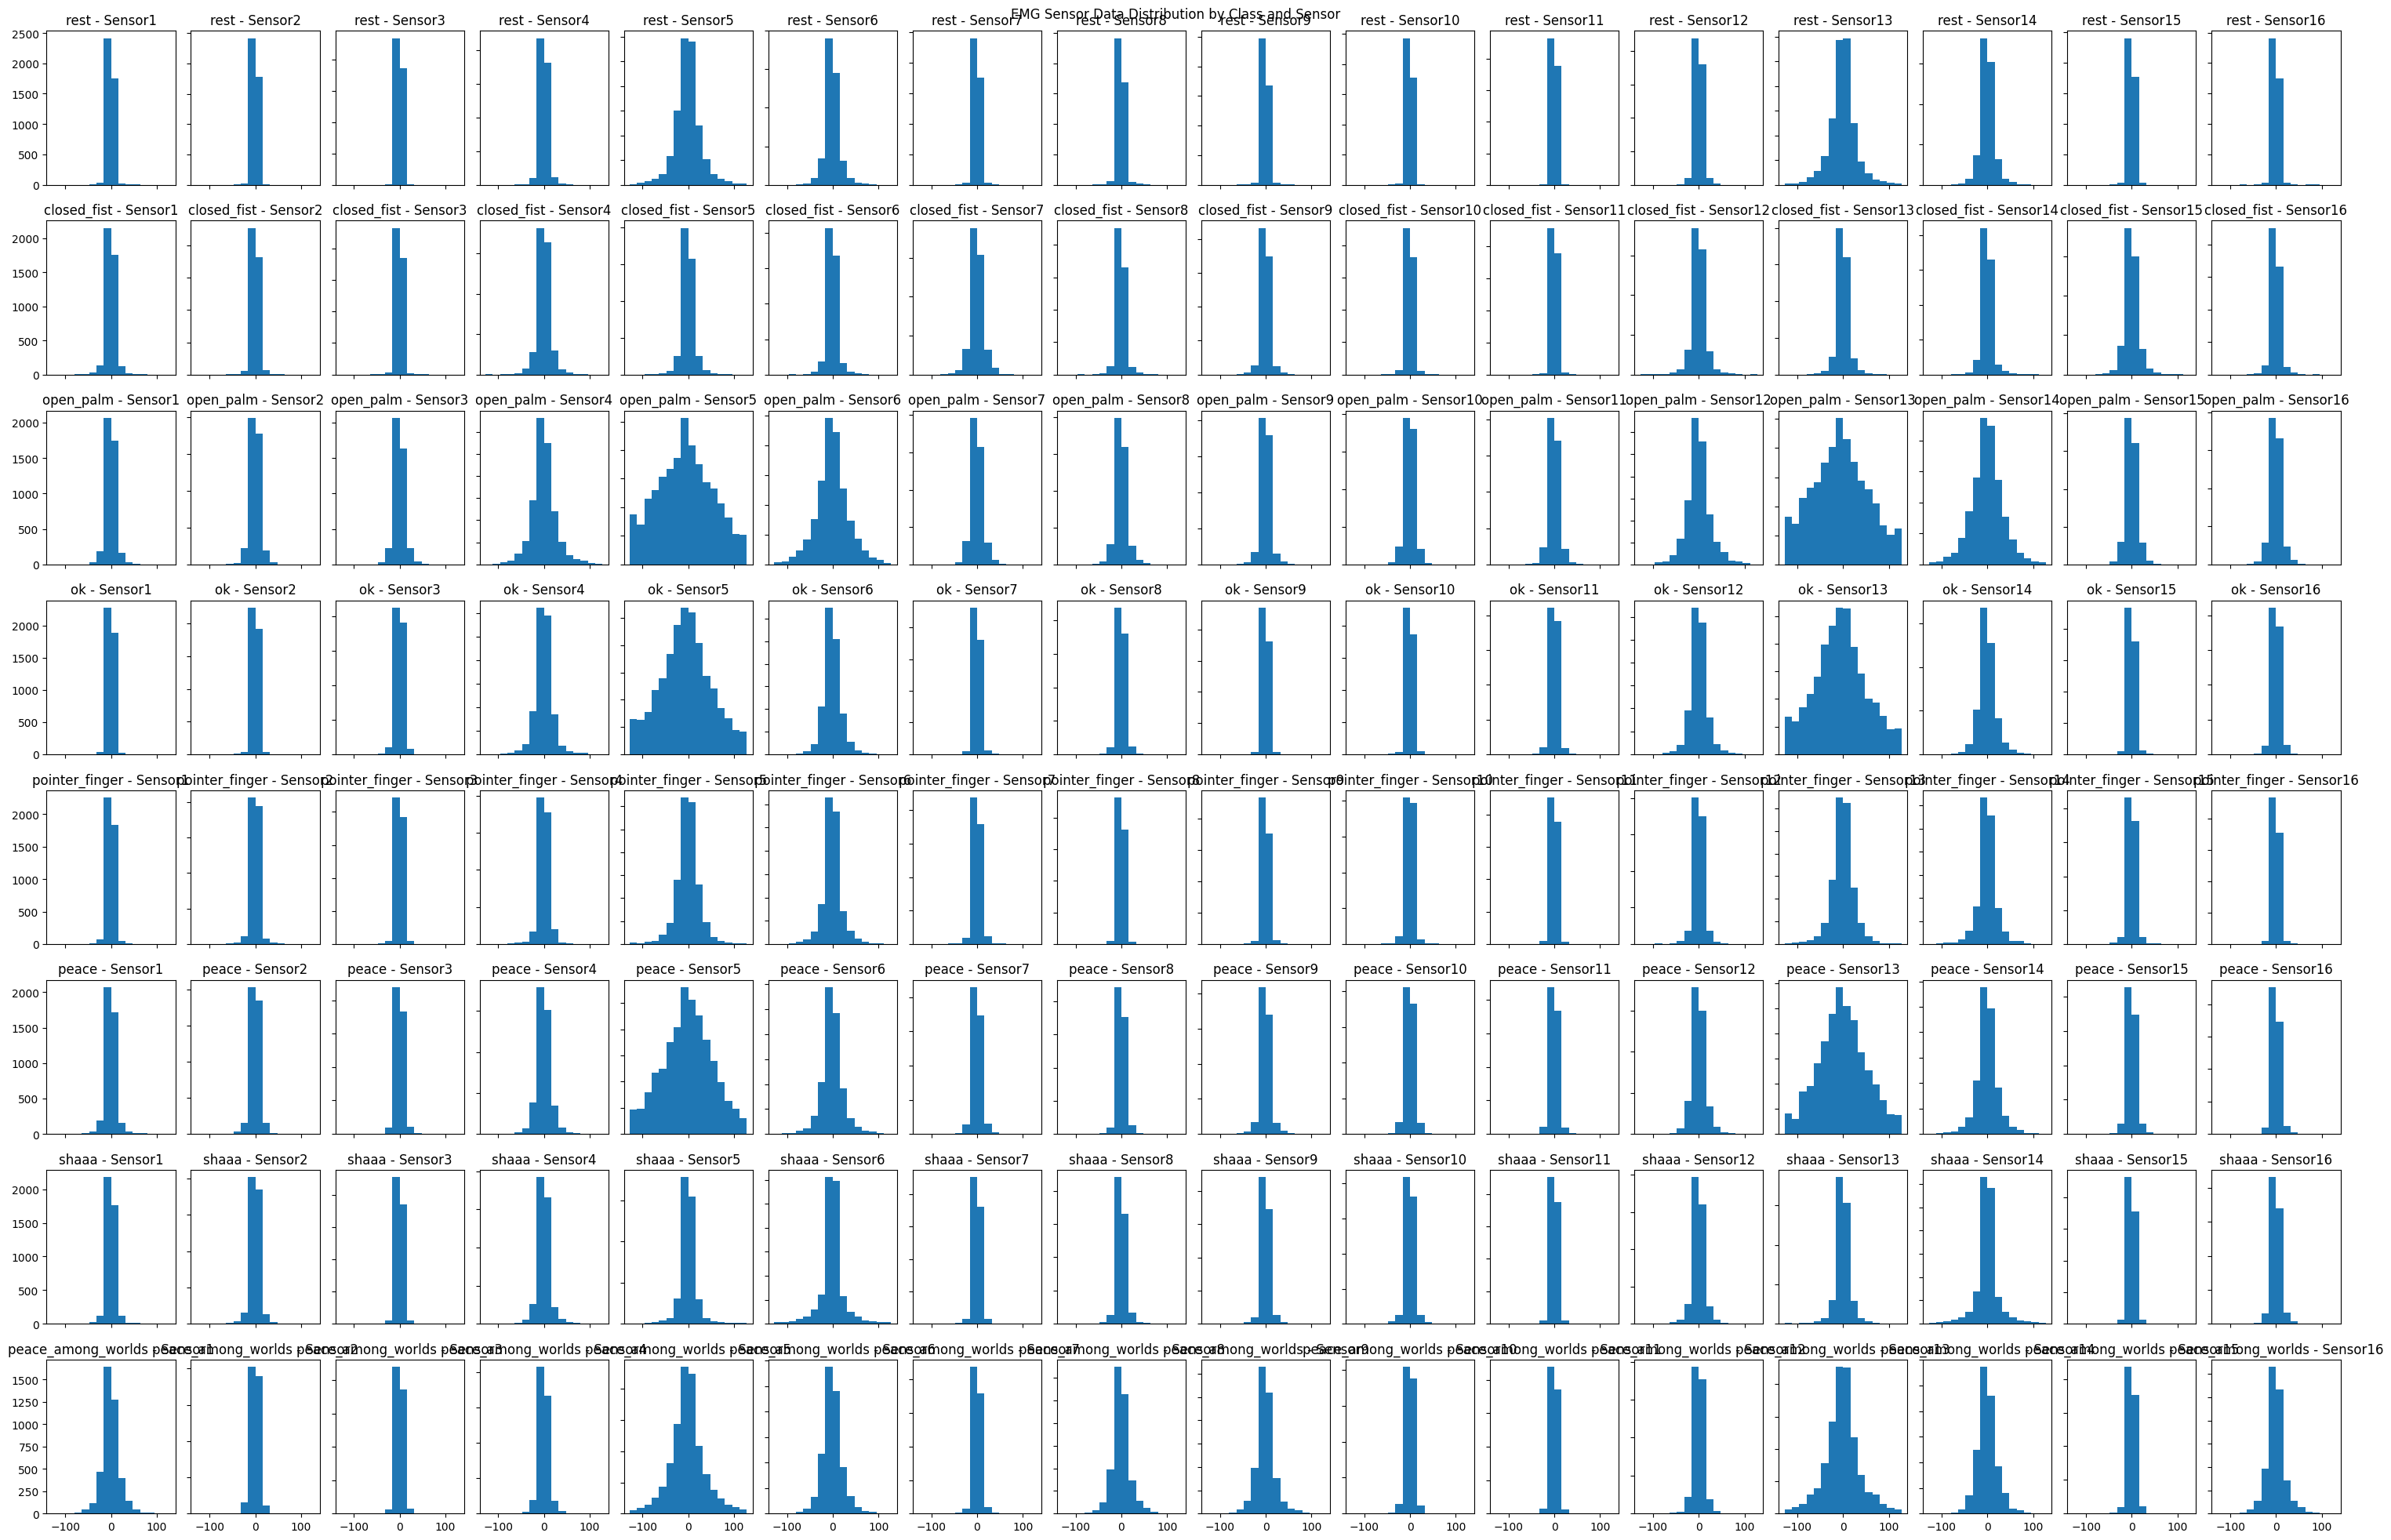

In [101]:
# Set up the subplot grid for all 16 sensors x 8 classes
fig, axs = plt.subplots(8, 16, figsize=(30, 20))
fig.suptitle('EMG Sensor Data Distribution by Class and Sensor')

bins = np.arange(-128, 129, 16) # Create bins from -128 to 128 in steps of 16

for class_id, class_name in CLASSES.items():
   class_data = df[df['Label'] == class_id]
   
   for sensor in range(16):
       sensor_col = f'Sensor{sensor+1}'
       sensor_data = class_data[sensor_col]
       
       axs[class_id, sensor].hist(sensor_data, bins=bins)
       axs[class_id, sensor].set_title(f'{CLASSES[class_id]} - {sensor_col}')
       
       # Only show y-axis labels for leftmost plots
       if sensor != 0:
           axs[class_id, sensor].set_yticklabels([])
           
       # Only show x-axis labels for bottom plots
       if class_id != 7:
           axs[class_id, sensor].set_xticklabels([])

plt.tight_layout()
plt.show()

## Scale and clean the data, then train the model

In [ ]:
X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# filter for valid classes because the data is not clean
valid_classes = [0, 1, 2, 3, 4, 5, 6, 7]
mask_train = y_train.isin(valid_classes)
mask_test = y_test.isin(valid_classes)

# apply the mask to the training and testing data
X_train_filtered = X_train_scaled[mask_train]
y_train_filtered = y_train[mask_train]

X_test_filtered = X_test_scaled[mask_test]
y_test_filtered = y_test[mask_test]

# one hot encode the target data
y_train_categorical = to_categorical(y_train_filtered, num_classes=8)
y_test_categorical = to_categorical(y_test_filtered, num_classes=8)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_filtered.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax'))  # Softmax for 8 output classes

# Compile the model with categorical crossentropy for multi-class classification
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Train the model using the filtered training data
model.fit(X_train_filtered, y_train_categorical, epochs=100, batch_size=64, validation_split=0.2)

# Evaluate the model on the filtered test set
test_loss, test_acc = model.evaluate(X_test_filtered, y_test_categorical)

print(f"Test accuracy: {test_acc}")

Epoch 1/100


c:\Users\willi\Desktop\Uni\3rd_year\NLP\CW1\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [106]:
# Save the model
model.save(MODEL_PATH)

# Save the scaler and the column names to a pickle file
with open(METADATA_PATH, 'wb') as f:
    pickle.dump((scaler, X_train.columns), f)

In [108]:
# emg_data = [[2,-11,-11,-38,-26,-1,-3,-11,], [-2,4,14,26,45,66,19,25]]
# emg_data = [[-4,2,2,1,-29,10,-1,-4], [4,-3,-4,9,6,2,2,-2]]
emg_data = [[-7,-9,-14,-55,-117,-25,-11], [-8,8,8,20,50,98,9,12,5]]

# emg_data = [[0, 0, 0, 0, 100, 0, 0, 0], [0, 0, 0, 0, 100, 0, 0, 0]]

sensor1_data, sensor2_data = emg_data

emg_features = np.concatenate((sensor1_data, sensor2_data))
emg_features_df = pd.DataFrame([emg_features], columns=X_train.columns)

emg_features_scaled = scaler.transform(emg_features_df)
emg_features_reshaped = emg_features_scaled.reshape(1, -1)

prediction = model.predict(emg_features_reshaped)
predicted_class = np.argmax(prediction)

# print(f"Probabilities: {prediction}")

print(f"Predicted class: {predicted_class} - {CLASSES[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted class: 3 - ok
